In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# we.py

import gzip
from __future__ import print_function, division
import re
import sys
import numpy as np
import scipy.sparse
from sklearn.decomposition import PCA
if sys.version_info[0] < 3:
    import io
    open = io.open
else:
    unicode = str
"""
Tools for debiasing word embeddings

Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings
Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama, and Adam Kalai
2016
"""

DEFAULT_NUM_WORDS = 27000
FILENAMES = {"g_wiki": "glove.6B.300d.small.txt",
             "g_twitter": "glove.twitter.27B.200d.small.txt",
             "g_crawl": "glove.840B.300d.small.txt",
             "w2v": "GoogleNews-word2vec.small.txt",
             "w2v_large":  "GoogleNews-word2vec.txt"}


def dedup(seq):
    seen = set()
    return [x for x in seq if not (x in seen or seen.add(x))]


def safe_word(w):
    # ignore words with numbers, etc.
    # [a-zA-Z\.'_\- :;\(\)\]] for emoticons
    return (re.match(r"^[a-z_]*$", w) and len(w) < 20 and not re.match(r"^_*$", w))


def to_utf8(text, errors='strict', encoding='utf8'):
    """Convert a string (unicode or bytestring in `encoding`), to bytestring in utf8."""
    if isinstance(text, unicode):
        return text.encode('utf8')
    # do bytestring -> unicode -> utf8 full circle, to ensure valid utf8
    return unicode(text, encoding, errors=errors).encode('utf8')


class WordEmbedding:
    def __init__(self, fname):
        self.thresh = None
        self.max_words = None
        self.desc = fname
        print("*** Reading data from " + fname)
        if fname.endswith(".bin") or fname.endswith(".bin.gz"):
            import gensim.models
            model =gensim.models.KeyedVectors.load_word2vec_format(fname, binary=True)
            words = model.index_to_key
            # words = sorted([w for w in model.vocab], key=lambda w: model.vocab[w].index)
            vecs = [np.array(model[w]) for w in words]
        else:
            vecs = []
            words = []

            with open(fname, "r", encoding='utf8') as f:
                for line in f:
                    s = line.split()
                    v = np.array([float(x) for x in s[1:]])
                    if len(vecs) and vecs[-1].shape!=v.shape:
                        print("Got weird line", line)
                        continue
    #                 v /= np.linalg.norm(v)
                    words.append(s[0])
                    vecs.append(v)
        self.vecs = np.array(vecs, dtype='float32')
        self.vecs_matrix = np.vstack(self.vecs)
        self.words = words
        self.reindex()
        norms = np.linalg.norm(self.vecs, axis=1)
        if max(norms)-min(norms) > 0.0001:
            self.normalize()

    def reindex(self):
        self.index = {w: i for i, w in enumerate(self.words)}
        self.n, self.d = self.vecs.shape
        assert self.n == len(self.words) == len(self.index)
        self._neighbors = None
        print(self.n, "words of dimension", self.d, ":", ", ".join(self.words[:4] + ["..."] + self.words[-4:]))

    def v(self, word):
        return self.vecs[self.index[word]]

    def diff(self, word1, word2):
        v = self.vecs[self.index[word1]] - self.vecs[self.index[word2]]
        return v/np.linalg.norm(v)

    def normalize(self):
        self.desc += ", normalize"
        self.vecs /= np.linalg.norm(self.vecs, axis=1)[:, np.newaxis]
        self.reindex()

    def shrink(self, numwords):
        self.desc += ", shrink " + str(numwords)
        self.filter_words(lambda w: self.index[w]<numwords)

    def filter_words(self, test):
        """
        Keep some words based on test, e.g. lambda x: x.lower()==x
        """
        self.desc += ", filter"
        kept_indices, words = zip(*[[i, w] for i, w in enumerate(self.words) if test(w)])
        self.words = list(words)
        self.vecs = self.vecs[kept_indices, :]
        self.reindex()

    def save(self, filename):
        with open(filename, "w") as f:
            f.write("\n".join([w+" " + " ".join([str(x) for x in v]) for w, v in zip(self.words, self.vecs)]))
        print("Wrote", self.n, "words to", filename)

    def save_w2v(self, filename, binary=True):
      with gzip.open(filename, 'wb') as fout:
          fout.write(to_utf8("%s %s\n" % self.vecs.shape))
          # Store in sorted order: most frequent words at the top
          for i, word in enumerate(self.words):
              row = self.vecs[i]
              if binary:
                  fout.write(to_utf8(word) + b" " + row.tostring())
              else:
                  fout.write(to_utf8("%s %s\n" % (word, ' '.join("%f" % val for val in row))))

    def remove_directions(self, directions): #directions better be orthogonal
        self.desc += ", removed"
        for direction in directions:
            self.desc += " "
            if type(direction) is np.ndarray:
                v = direction / np.linalg.norm(direction)
                self.desc += "vector "
            else:
                w1, w2 = direction
                v = self.diff(w1, w2)
                self.desc += w1 + "-" + w2
            self.vecs = self.vecs - self.vecs.dot(v)[:, np.newaxis].dot(v[np.newaxis, :])
        self.normalize()

    def compute_neighbors_if_necessary(self, thresh, max_words):
        thresh = float(thresh) # dang python 2.7!
        if self._neighbors is not None and self.thresh == thresh and self.max_words == max_words:
            return
        print("Computing neighbors")
        self.thresh = thresh
        self.max_words = max_words
        vecs = self.vecs[:max_words]
        dots = vecs.dot(vecs.T)
        dots = scipy.sparse.csr_matrix(dots * (dots >= 1-thresh/2))
        from collections import Counter
        rows, cols = dots.nonzero()
        nums = list(Counter(rows).values())
        print("Mean:", np.mean(nums)-1)
        print("Median:", np.median(nums)-1)
        rows, cols, vecs = zip(*[(i, j, vecs[i]-vecs[j]) for i, j, x in zip(rows, cols, dots.data) if i<j])
        self._neighbors = rows, cols, np.array([v/np.linalg.norm(v) for v in vecs])

    def neighbors(self, word, thresh=1):
        dots = self.vecs.dot(self.v(word))
        return [self.words[i] for i, dot in enumerate(dots) if dot >= 1-thresh/2]

    def more_words_like_these(self, words, topn=50, max_freq=100000):
        v = sum(self.v(w) for w in words)
        dots = self.vecs[:max_freq].dot(v)
        thresh = sorted(dots)[-topn]
        words = [w for w, dot in zip(self.words, dots) if dot>=thresh]
        return sorted(words, key=lambda w: self.v(w).dot(v))[-topn:][::-1]

    def best_analogies_dist_thresh(self, v, thresh=1, topn=500, max_words=50000):
        """Metric is cos(a-c, b-d) if |b-d|^2 < thresh, otherwise 0
        """
        vecs, vocab = self.vecs[:max_words], self.words[:max_words]
        self.compute_neighbors_if_necessary(thresh, max_words)
        rows, cols, vecs = self._neighbors
        scores = vecs.dot(v/np.linalg.norm(v))
        pi = np.argsort(-abs(scores))

        ans = []
        usedL = set()
        usedR = set()
        for i in pi:
            if abs(scores[i])<0.001:
                break
            row = rows[i] if scores[i] > 0 else cols[i]
            col = cols[i] if scores[i] > 0 else rows[i]
            if row in usedL or col in usedR:
                continue
            usedL.add(row)
            usedR.add(col)
            ans.append((vocab[row], vocab[col], abs(scores[i])))
            if len(ans)==topn:
                break

        return ans


def viz(analogies):
    print("\n".join(str(i).rjust(4)+a[0].rjust(29) + " | " + a[1].ljust(29) + (str(a[2]))[:4] for i, a in enumerate(analogies)))


def text_plot_words(xs, ys, words, width = 90, height = 40, filename=None):
    PADDING = 10 # num chars on left and right in case words spill over
    res = [[' ' for i in range(width)] for j in range(height)]
    def rescale(nums):
        a = min(nums)
        b = max(nums)
        return [(x-a)/(b-a) for x in nums]
    print("x:", (min(xs), max(xs)), "y:",(min(ys),max(ys)))
    xs = rescale(xs)
    ys = rescale(ys)
    for (x, y, word) in zip(xs, ys, words):
        i = int(x*(width - 1 - PADDING))
        j = int(y*(height-1))
        row = res[j]
        z = list(row[i2] != ' ' for i2 in range(max(i-1, 0), min(width, i + len(word) + 1)))
        if any(z):
            continue
        for k in range(len(word)):
            if i+k>=width:
                break
            row[i+k] = word[k]
    string = "\n".join("".join(r) for r in res)
#     return string
    if filename:
        with open(filename, "w", encoding="utf8") as f:
            f.write(string)
        print("Wrote to", filename)
    else:
        print(string)


def doPCA(pairs, embedding, num_components = 10):
    matrix = []
    for a, b in pairs:
        center = (embedding.v(a) + embedding.v(b))/2
        matrix.append(embedding.v(a) - center)
        matrix.append(embedding.v(b) - center)
    matrix = np.array(matrix)
    pca = PCA(n_components = num_components)
    pca.fit(matrix)
    # bar(range(num_components), pca.explained_variance_ratio_)
    return pca


def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

In [21]:
# debias.py

from __future__ import print_function, division
import json
import numpy as np
import argparse
import sys
import scipy
if sys.version_info[0] < 3:
    import io
    open = io.open
"""
Hard-debias embedding

Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings
Tolga Bolukbasi, Kai-Wei Chang, James Zou, Venkatesh Saligrama, and Adam Kalai
2016
"""

def empirical_covariance_matrix(data):
    """
    Compute the empirical covariance matrix of a data matrix.

    Parameters:
    - data: The input data matrix.

    Returns:
    - The empirical covariance matrix.
    """
    centered_data = data - np.mean(data, axis=0)
    outer_product = np.dot(centered_data.T, centered_data)
    covariance_matrix = outer_product / (data.shape[0] - 1)

    return covariance_matrix

def create_initial_guess(orthogonal_vectors):
    """Perform Gram-Schmidt process on a random vector with respect to a list of orthogonal vectors."""
    # Initialize the orthogonalized vector with the random vector
    orthogonalized_vector = np.random.rand(300)

    # Iterate over each orthogonal vector
    for orthogonal_vector in orthogonal_vectors:
        # Project the orthogonalized vector onto the orthogonal vector
        orthogonal_vector = orthogonal_vector.reshape(-1)
        projection = np.dot(orthogonalized_vector, orthogonal_vector) / np.dot(orthogonal_vector, orthogonal_vector)
        projection *= orthogonal_vector

        # Subtract the projection from the orthogonalized vector
        orthogonalized_vector -= projection

    # Normalize the orthogonalized vector
    normalized_orthogonalized_vector = orthogonalized_vector / np.linalg.norm(orthogonalized_vector)

    return normalized_orthogonalized_vector

def find_indirect_directions(E, gender_components, iters):
    W = E.vecs_matrix
    cov = empirical_covariance_matrix(W)
    g = gender_components[0].reshape(-1, 1)
    mu_g = np.full((W.shape[0], 1), np.mean(W @ g))
    g_term = W @ g - mu_g
    indirect_directions = []
    gender_correlations = []
    all_directions = [row for row in gender_components]

    def objective_function(x):
      x = x.reshape(-1, 1)

      cov_x_g = np.sum((x @ g.T) * cov)
      sd_x = np.sqrt(np.sum((x @ x.T) * cov))

      return -(cov_x_g / sd_x).item()

      # W_x = W @ x
      # residual = W_x - np.mean(W_x)
      # return -(np.dot(residual.reshape(-1), g_term.reshape(-1))/ np.linalg.norm(residual)).item()

    def create_orthogonal_constraint(direction):
      def constraint(x):
          x = x.reshape(-1, 1)
          return np.squeeze(x.T @ direction)
      return constraint

    def magnitude_constraint(x):
        x = x.reshape(-1, 1)
        return np.squeeze(x.T @ x - 1) # magnitude 1

    constraints = [{'type': 'eq', 'fun': magnitude_constraint}]

    for gender_component in gender_components:
      constraints.append({'type': 'eq', 'fun': create_orthogonal_constraint(gender_component)})

    for iter in range(iters):
      print(f"Iteration {iter}")
      # Perform this iteration
      initial_guess = create_initial_guess(all_directions)
      result = scipy.optimize.minimize(objective_function, initial_guess, constraints=constraints)
      new_direction = result.x.reshape((-1, 1))

      # Set up next iteration
      indirect_directions.append(new_direction)
      all_directions.append(new_direction)
      gender_correlations.append(-objective_function(new_direction) / np.linalg.norm(g_term))
      constraints.append({'type': 'eq', 'fun': create_orthogonal_constraint(new_direction)})

    for i in range(len(indirect_directions)):
      indirect_directions[i] = indirect_directions[i].reshape(-1)

    return indirect_directions, gender_correlations

def debias(E, gender_specific_words, definitional, equalize, indirect_bias_threshold):
    gender_components = doPCA(definitional, E).components_
    gender_direction = gender_components[0]
    indirect_directions, gender_correlations = find_indirect_directions(E, gender_components, 2)
    removed_subspace = [gender_direction]

    for i in range(len(indirect_directions)):
      if gender_correlations[i] < indirect_bias_threshold:
        break
      removed_subspace.append(indirect_directions[i])

    specific_set = set(gender_specific_words)
    for i, w in enumerate(E.words):
        if w not in specific_set:
            for direction in removed_subspace:
              E.vecs[i] = drop(E.vecs[i], direction)
    E.normalize()
    candidates = {x for e1, e2 in equalize for x in [(e1.lower(), e2.lower()),
                                                     (e1.title(), e2.title()),
                                                     (e1.upper(), e2.upper())]}
    for (a, b) in candidates:
        if (a in E.index and b in E.index):
            for direction in removed_subspace:
              y = drop((E.v(a) + E.v(b)) / 2, direction)
              z = np.sqrt(1 - np.linalg.norm(y)**2)
              if (E.v(a) - E.v(b)).dot(direction) < 0:
                  z = -z
              E.vecs[E.index[a]] = z * direction + y
              E.vecs[E.index[b]] = -z * direction + y
    E.normalize()

In [18]:
import time

def objective_function(x):
    x = x.reshape(-1, 1)
    start = time.time()
    W_x = W @ x
    end = time.time()
    print(end - start, end=' ')
    residual = W_x - np.mean(W_x)
    result = -(np.dot(residual.reshape(-1), g_term.reshape(-1))/ np.linalg.norm(residual)).item()
    end = time.time()
    print(end - start)
    return result

def create_orthogonal_constraint(direction):
  def constraint(x):
      x = x.reshape(-1, 1)
      return np.squeeze(x.T @ direction)
  return constraint

def magnitude_constraint(x):
    x = x.reshape(-1, 1)
    return np.squeeze(x.T @ x - 1) # magnitude 1

constraints = [{'type': 'eq', 'fun': magnitude_constraint}]

for gender_component in gender_components:
  constraints.append({'type': 'eq', 'fun': create_orthogonal_constraint(gender_component)})

result = scipy.optimize.minimize(objective_function, initial_guess, constraints=constraints)

0.2886795997619629 0.29162049293518066
0.3528919219970703 0.3557448387145996
0.5262596607208252 0.5427355766296387
0.6439225673675537 0.6494598388671875
0.4572889804840088 0.46048402786254883
0.35716962814331055 0.36384034156799316
0.41629791259765625 0.42232441902160645
0.3358149528503418 0.33855247497558594
0.28011369705200195 0.28281283378601074
0.29091310501098633 0.2996039390563965
0.28205156326293945 0.28476548194885254
0.28848814964294434 0.29121851921081543
0.2789449691772461 0.28177356719970703
0.28930163383483887 0.291947603225708
0.2844099998474121 0.28709864616394043
0.28490233421325684 0.287625789642334
0.2843611240386963 0.2870161533355713
0.28932833671569824 0.29204583168029785
0.28255152702331543 0.2852342128753662
0.28143310546875 0.28461122512817383
0.2964751720428467 0.29917454719543457
0.2806284427642822 0.2834610939025879
0.28152990341186523 0.28417110443115234
0.2822573184967041 0.2851989269256592
0.29929637908935547 0.3021206855773926
0.28450560569763184 0.287151

KeyboardInterrupt: 

In [5]:
import json

embedding_filename = '/content/drive/MyDrive/Courses/Sophomore Spring Courses/CS226R/Debiasing Algorithm Data/GoogleNews-vectors-negative300-SLIM.bin.gz'
definitional_filename = '/content/drive/MyDrive/Courses/Sophomore Spring Courses/CS226R/Debiasing Algorithm Data/definitional_pairs.json'
gendered_words_filename = '/content/drive/MyDrive/Courses/Sophomore Spring Courses/CS226R/Debiasing Algorithm Data/gender_specific_full.json'
equalize_filename = '/content/drive/MyDrive/Courses/Sophomore Spring Courses/CS226R/Debiasing Algorithm Data/equalize_pairs.json'
debiased_filename = '/content/drive/MyDrive/Courses/Sophomore Spring Courses/CS226R/Debiasing Algorithm Data/word2vec_custom_debiased_slimmed.bin.gz'

with open(definitional_filename, "r") as f:
    defs = json.load(f)
print("definitional", defs)

with open(equalize_filename, "r") as f:
    equalize_pairs = json.load(f)

with open(gendered_words_filename, "r") as f:
    gender_specific_words = json.load(f)
print("gender specific", len(gender_specific_words), gender_specific_words[:10])

E = WordEmbedding(embedding_filename)

definitional [['woman', 'man'], ['girl', 'boy'], ['she', 'he'], ['mother', 'father'], ['daughter', 'son'], ['gal', 'guy'], ['female', 'male'], ['her', 'his'], ['herself', 'himself'], ['Mary', 'John']]
gender specific 1441 ['he', 'his', 'He', 'her', 'she', 'him', 'She', 'man', 'women', 'men']
*** Reading data from /content/drive/MyDrive/Courses/Sophomore Spring Courses/CS226R/Debiasing Algorithm Data/GoogleNews-vectors-negative300-SLIM.bin.gz
299567 words of dimension 300 : in, for, that, is, ..., StoreFront_e, KUNDI, tricorne, RAFFAELE


In [ ]:
debiased_filename = '/content/drive/MyDrive/Courses/Sophomore Spring Courses/CS226R/Debiasing Algorithm Data/word2vec_custom_debiased_slimmed (1).bin.gz'

print("Debiasing...")
debias(E, gender_specific_words, defs, equalize_pairs, 0.6)

print("Saving to file...")
if embedding_filename[-7:] == debiased_filename[-7:] == ".bin.gz":
    E.save_w2v(debiased_filename)
else:
    E.save(debiased_filename)

print("\n\nDone!\n")

Debiasing...
Iteration 0
Iteration 1


In [ ]:
pca_results = doPCA(defs, E)

eigenvalues = pca_results.explained_variance_
gender_components = pca_results.components_
gender_direction = gender_components[0]

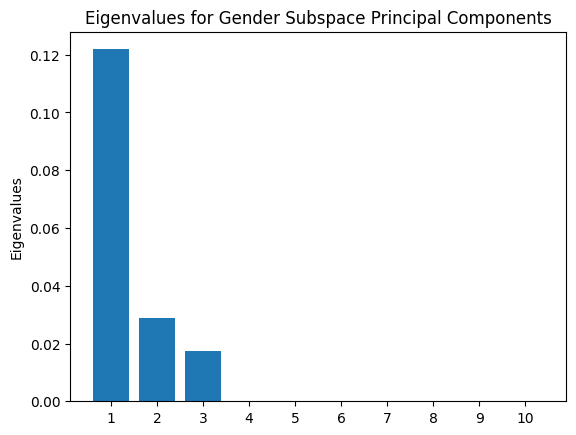

[1.2184689e-01 2.8695988e-02 1.7359711e-02 2.1229905e-15 5.2647275e-16
 3.6039727e-16 2.7809505e-16 2.1192357e-16 1.7448412e-16 1.0680265e-16]


In [ ]:
import matplotlib.pyplot as plt

# Example list
data = eigenvalues

# Create bar graph
plt.bar(range(1, len(data) + 1), data)

# Add labels to the x-axis
plt.xticks(range(1, len(data) + 1))

# Add labels to the y-axis and title
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues for Gender Subspace Principal Components')

# Show the plot
plt.show()

print(eigenvalues)


In [ ]:
print(gender_components.shape)

(10, 300)


In [ ]:
indirect_directions, gender_correlations = find_indirect_directions(E, gender_components, 10)

In [ ]:
indirect_direction = indirect_directions[0]

In [ ]:
print(gender_correlations)

[0.792407636461794, 0.6537880299166302, 0.5814085181438774, 0.5298950207486891, 0.47209784103526564, 0.38973964583289084, 0.2961662793524041, 0.22939776667734155, 0.1748765428022916, 0.13059280493657335]


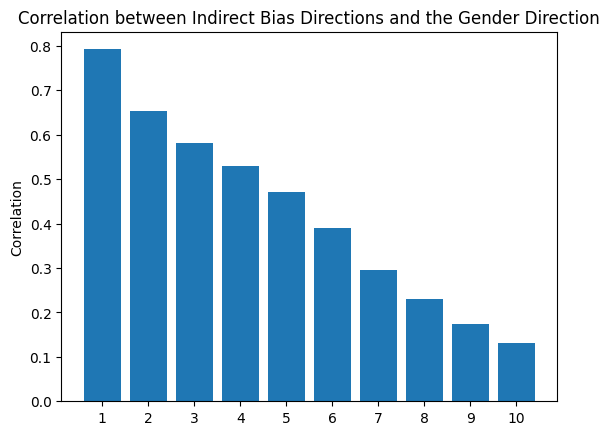

In [ ]:
import matplotlib.pyplot as plt

# Example list
data = gender_correlations

# Create bar graph
plt.bar(range(1, len(data) + 1), data)

# Add labels to the x-axis
plt.xticks(range(1, len(data) + 1))

# Add labels to the y-axis and title
plt.ylabel('Correlation')
plt.title('Correlation between Indirect Bias Directions and the Gender Direction')

# Show the plot
plt.show()


In [ ]:
def cosine_similarity(v1, v2):
    """Compute cosine similarity between two vectors."""
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

similarities = sorted([cosine_similarity(row, indirect_direction) for row in gender_components], key = lambda x: abs(x), reverse=True)

# Print cosine similarities
print("Cosine similarities for row:", similarities)

Cosine similarities for row: [-1.365586467581041e-15, 1.0664191062922057e-15, 8.552170509568238e-16, -5.850343473507097e-16, -5.685542693609263e-16, 1.971075809634262e-16, -1.86265557605735e-16, 1.7390561557111474e-16, 1.0505899743558031e-16, 9.237380577717566e-17]
